In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score
from tensorflow.keras import Sequential, layers
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", False)
from sklearn.metrics import mean_absolute_percentage_error
from datetime import date, timedelta, datetime
from sklearn.metrics import r2_score
from tensorflow.keras.optimizers import Adam
######################################################
from gluonts.dataset.util import to_pandas
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx import Trainer
from gluonts.evaluation import make_evaluation_predictions
import matplotlib.pyplot as plt

2022-09-15 13:35:41.857889: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-15 13:35:41.857913: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/demange/.pyenv/versions/lewagon/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


# Prepare dataset

## Load data

In [2]:
df = pd.read_csv('../data/data_preparation.csv', index_col=[0])

## Fill missing data

In [3]:
def replace_val(df,date1,date2): #on remplace les NaN dans l intervalle de date
    for col in df.columns:
        imputer = KNNImputer(n_neighbors=7) # Instantiate a SimpleImputer object with your strategy of choice
        imputer.fit(df[[col]]) # Call the "fit" method on the object
        df[col] = imputer.transform(df[[col]]) # Call the "transform" method on the object

In [4]:
df['Date']=pd.to_datetime(df['Date'], errors='coerce')
df = df.set_index('Date').asfreq('D')
replace_val(df,'2022-04-30','2022-05-06')

### Select relevant features

In [5]:
df.drop(columns=['t - 1', 't - 2', 't - 3', 't - 4', 't - 5',
       't - 6', 't - 7', 't - 8', 't - 9', 't - 10', 't - 11', 't - 12',
       't - 13', 't - 14', 't - 15', 't - 16', 't - 17', 't - 18', 't - 19',
       't - 20', 't - 21', 't - 22', 't - 23', 't - 24', 't - 25', 't - 26',
       't - 27', 't - 28', 't - 29', 't - 30','sin365_1', 'cos365_1', 'sin365_2', 'cos365_2',
       'sin365_3', 'cos365_3','bank_holiday', 'school_holidays',
       'season','Thermique (MW)', 'Nucléaire (MW)', 'Eolien (MW)', 'Solaire (MW)',
       'Hydraulique (MW)', 'Pompage (MW)', 'Bioénergies (MW)',
       'Ech. physiques (MW)', 'Stockage batterie', 'Déstockage batterie',
       'Eolien terrestre', 'Eolien offshore', 'TCO Thermique (%)',
       'TCH Thermique (%)', 'TCO Nucléaire (%)', 'TCH Nucléaire (%)',
       'TCO Eolien (%)', 'TCH Eolien (%)', 'TCO Solaire (%)',
       'TCH Solaire (%)', 'Column 30','Code INSEE région','sin_month', 'cos_month',
        'num_day',
        'YEAR', 'MONTH', 'DAY',
        'T2MDEW', 'T2MWET', 'TS', 'T2M_RANGE',
       'T2M_MAX', 'T2M_MIN','PS', 'QV2M','WS10M','WS50M','RH2M','week_day' #temoin
        #'PRECTOTCORR' # PRECTOTCORR is bias-corrected total precipitation
        #'sin_day','cos_day'
                ],inplace=True)

In [6]:
df['id']='A'

In [7]:
df

,Consommation (MW),T2M,PRECTOTCORR,sin_day,cos_day,id
Date,,,,,,
2013-02-02,262321.0,5.55,1.94,-0.974928,-0.222521,A
2013-02-03,273743.0,2.96,0.02,-0.781831,0.623490,A
2013-02-04,295369.0,4.67,0.00,0.000000,1.000000,A
2013-02-05,287424.0,6.65,0.19,0.781831,0.623490,A
2013-02-06,294084.0,2.71,0.10,0.974928,-0.222521,A
...,...,...,...,...,...,...
2022-05-11,218296.0,18.10,0.00,0.974928,-0.222521,A
2022-05-12,209770.0,18.13,0.00,0.433884,-0.900969,A
2022-05-13,201061.0,18.01,0.10,-0.433884,-0.900969,A


In [8]:
N_test = 100

In [9]:
df_train=df.iloc[:-N_test]

In [10]:
df_test=df.iloc[-N_test:]

In [11]:
df_train.head()

,Consommation (MW),T2M,PRECTOTCORR,sin_day,cos_day,id
Date,,,,,,
2013-02-02,262321.0,5.55,1.94,-0.974928,-0.222521,A
2013-02-03,273743.0,2.96,0.02,-0.781831,0.623490,A
2013-02-04,295369.0,4.67,0.00,0.000000,1.000000,A
2013-02-05,287424.0,6.65,0.19,0.781831,0.623490,A
2013-02-06,294084.0,2.71,0.10,0.974928,-0.222521,A


In [12]:
#df=df.copy()
#df['Consommation (MW)'].iloc[-N_test:]=0 ###Commenter cette ligne pour preuve du bon fonctionnement

In [13]:
exo_feature = ['T2M','PRECTOTCORR', 'sin_day', 'cos_day']

In [14]:
ds = PandasDataset(df_train, target="Consommation (MW)",feat_dynamic_real=exo_feature)

In [15]:
estimator = DeepAREstimator(
    freq=ds.freq, prediction_length=N_test, trainer=Trainer(epochs=15,learning_rate=0.0005),
    use_feat_dynamic_real=True,
    batch_size=16,
    num_layers=3,
    num_cells=80
)

predictor = estimator.train(ds)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.09it/s, epoch=15/15, avg_epoch_loss=10.1]


In [16]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=ds,#dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation, is useful for confidence interval
)

In [17]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [18]:
# first entry of the time series list
ts_entry = tss[0]

In [19]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(
    -1,
)

array([262321., 273743., 295369., 287424., 294084.], dtype=float32)

In [20]:
# first entry of dataset.test
dataset_test_entry = next(iter(ds))

In [21]:
# first 5 values
dataset_test_entry["target"][:5]

array([262321., 273743., 295369., 287424., 294084.], dtype=float32)

In [22]:
forecast_entry = forecasts[0]

In [23]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 100)
Start date of the forecast window: 2021-10-28
Frequency of the time series: <Day>


In [24]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [
        f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color="g")
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()
    return ax

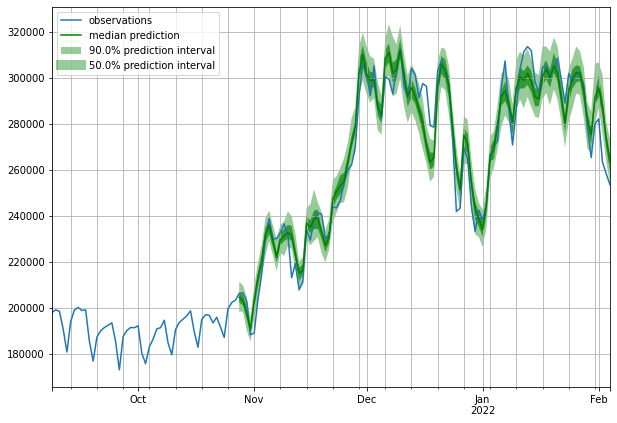

<AxesSubplot:>

In [25]:
plot_prob_forecasts(ts_entry, forecast_entry)

In [26]:
df_test

,Consommation (MW),T2M,PRECTOTCORR,sin_day,cos_day,id
Date,,,,,,
2022-02-05,242500.0,7.63,0.00,-0.974928,-0.222521,A
2022-02-06,247465.0,7.06,0.00,-0.781831,0.623490,A
2022-02-07,252970.0,6.89,0.00,0.000000,1.000000,A
2022-02-08,258963.0,7.96,0.00,0.781831,0.623490,A
2022-02-09,258503.0,8.03,0.00,0.974928,-0.222521,A
...,...,...,...,...,...,...
2022-05-11,218296.0,18.10,0.00,0.974928,-0.222521,A
2022-05-12,209770.0,18.13,0.00,0.433884,-0.900969,A
2022-05-13,201061.0,18.01,0.10,-0.433884,-0.900969,A


In [27]:
ds = PandasDataset(df, target="Consommation (MW)",feat_dynamic_real=exo_feature)

In [28]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=ds,#dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation, is useful for confidence interval
)

In [29]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [30]:
# first entry of the time series list
ts_entry = tss[0]

In [31]:
forecast_entry = forecasts[0]

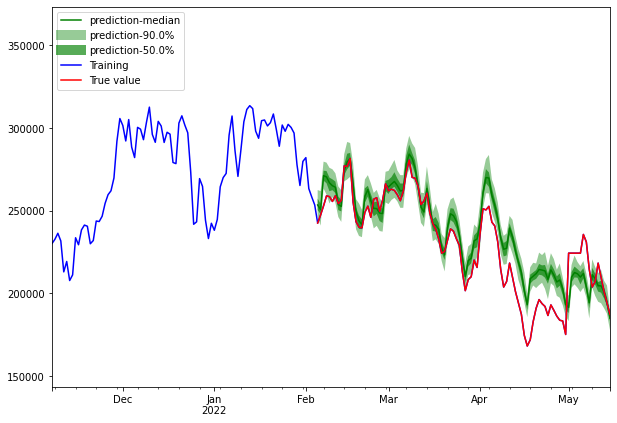

In [32]:
plot_length = 100
prediction_intervals = (50.0, 90.0)
legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1] + ['true_value']
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

forecast_entry.plot(prediction_intervals=prediction_intervals, color="g",label='prediction')
plt.plot(df['Consommation (MW)'],label='Training',color='blue')
plt.plot(ts_entry[-plot_length:],label='True value',color='red')
plt.legend(loc="upper left")
plt.xlim(left=df['Consommation (MW)'].index[3200])
#plt.xlim(left=ts_entry[-plot_length:].index[0])
plt.show()

In [33]:
df_test['Consommation (MW)'].index[0]

Timestamp('2022-02-05 00:00:00', freq='D')